In [1]:
import pandas as pd
import mysql.connector

# Connect to your MySQL database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="dentalclinic",
    database="bank"
)

# Load data
customers = pd.read_sql("SELECT * FROM customers", conn)
accounts = pd.read_sql("SELECT * FROM accounts", conn)
transactions = pd.read_sql("SELECT * FROM transactions", conn)

conn.close()


C:\Users\mehta\AppData\Local\Temp\ipykernel_28196\2545531714.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customers = pd.read_sql("SELECT * FROM customers", conn)
C:\Users\mehta\AppData\Local\Temp\ipykernel_28196\2545531714.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  accounts = pd.read_sql("SELECT * FROM accounts", conn)
C:\Users\mehta\AppData\Local\Temp\ipykernel_28196\2545531714.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  transactions = pd.read_sql("SELECT * FROM transactions", conn)


In [2]:
# Merge accounts with customers
accounts_full = accounts.merge(customers, on='customer_id', how='left')

# Merge transactions with full account-customer info
tx_full = transactions.merge(accounts_full, on='account_id', how='left')

# Focus on debit transactions for spending insights
tx_debit = tx_full[tx_full['type'] == 'debit'].copy()


### Top 10 Customers by Total Spending

In [20]:
import plotly.express as px

top_spenders = tx_debit.groupby('name')['amount'].sum().nlargest(10).reset_index()

fig = px.bar(top_spenders, x='amount', y='name', orientation='h',
             color='amount', title='Top 10 Customers by Total Debit Spend')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


### Spend by Account Type

In [ ]:
account_type_summary = tx_debit.groupby('account_type')['amount'].sum().reset_index()

fig = px.pie(account_type_summary, names='account_type', values='amount',
             title='Total Spend by Account Type')
fig.show()


### Risk Score vs Total Spend

In [10]:
risk_summary = tx_debit.groupby('risk_score')['amount'].sum().reset_index()

fig = px.bar(risk_summary, x='risk_score', y='amount', title='Spending by Risk Score')
fig.show()


### Age Distribution of Customers

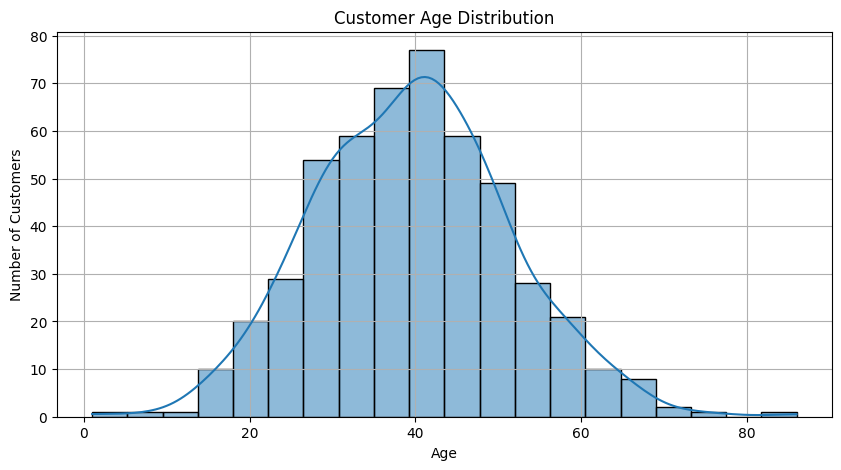

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(customers['age'], bins=20, kde=True)
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()


### Interactive Filters Using ipywidgets

In [12]:
from ipywidgets import interact

@interact(min_age=(18, 90, 1), max_age=(18, 90, 1))
def filter_age(min_age=25, max_age=60):
    subset = tx_debit[(tx_debit['age'] >= min_age) & (tx_debit['age'] <= max_age)]
    top = subset.groupby('name')['amount'].sum().nlargest(10).reset_index()
    
    fig = px.bar(top, x='amount', y='name', orientation='h',
                 title=f'Top Spenders Age {min_age}–{max_age}')
    fig.show()


interactive(children=(IntSlider(value=25, description='min_age', max=90, min=18), IntSlider(value=60, descript…

In [19]:
# Filter fraud cases
fraud = tx_full[tx_full['is_fraud'] == 1].copy()

# Total transactions
total_tx = tx_full.shape[0]
total_fraud = fraud.shape[0]

print(f"Total Transactions: {total_tx}")
print(f"Total Fraudulent Transactions: {total_fraud}")
print(f"Overall Fraud Rate: {round(total_fraud / total_tx * 100, 2)}%")


Total Transactions: 15913
Total Fraudulent Transactions: 462
Overall Fraud Rate: 2.9%


### Fraud by Transaction Type

In [14]:
import plotly.express as px

fraud_type = tx_full.groupby('type')['is_fraud'].agg(['sum', 'count'])
fraud_type['fraud_rate_pct'] = (fraud_type['sum'] / fraud_type['count']) * 100
fraud_type = fraud_type.reset_index()

fig = px.bar(fraud_type, x='type', y='fraud_rate_pct',
             title='Fraud Rate by Transaction Type',
             labels={'fraud_rate_pct': 'Fraud Rate (%)'})
fig.show()


### Fraud by Account Type

In [15]:
fraud_acct = fraud.groupby('account_type')['transaction_id'].count().reset_index()
fraud_acct.columns = ['account_type', 'fraud_count']

fig = px.bar(fraud_acct, x='account_type', y='fraud_count',
             title='Fraudulent Transactions by Account Type')
fig.show()


### Fraud by City

In [16]:
fraud_city = fraud.groupby('city')['transaction_id'].count().reset_index().sort_values('transaction_id', ascending=False).head(10)
fraud_city.columns = ['city', 'fraud_count']

fig = px.bar(fraud_city, x='fraud_count', y='city', orientation='h',
             title='Top 10 Cities by Fraudulent Transactions')
fig.show()
